# Train a VAE on L1000 Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd

sys.path.insert(0, "../../scripts")
from utils import load_data, infer_L1000_features
import matplotlib.pyplot as plt

from tensorflow import keras


from vae import VAE
from tensorflow.keras.models import Model, Sequential
import seaborn
import tensorflow as tf

In [14]:
# %load_ext nb_black

In [15]:
# np.random.seed(123)
# python_random.seed(123)
# tf.random.set_random_seed(1234)

In [3]:
data_splits = ["train", "valid", "test", "complete"]
# data_splits = ["train", "valid","test"]
data_dict = load_data(data_splits, dataset="L1000")
# data_dict["train"] = data_dict["train"][data_dict["train"].cell_id == "A549"].reset_index(drop = True)
# data_dict["valid"] = data_dict["valid"][data_dict["valid"].cell_id == "A549"].reset_index(drop = True)
# data_dict["test"] = data_dict["test"][data_dict["test"].cell_id == "A549"].reset_index(drop = True)
# data_dict["complete"] = data_dict["complete"][data_dict["complete"].cell_id == "A549"].reset_index(drop = True)

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
# Prepare data for training

meta_features = infer_L1000_features(data_dict["train"], metadata=True)
profile_features = infer_L1000_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(profile_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(profile_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(profile_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(profile_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [18]:
#shuffle columns
def shuffle_each_column(df):
    columns = df.columns
    df_copy = df.copy()
    for column in columns:
        df_copy[column] = df_copy[column].sample(frac=1).reset_index(drop=True)
    return (df_copy)

In [19]:
# train_features_df = shuffle_each_column(train_features_df)
# valid_features_df = shuffle_each_column(valid_features_df)
# test_features_df = shuffle_each_column(test_features_df)

In [5]:
print(train_features_df.shape)
train_features_df.head(3)

(94440, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.074578,-0.000776,-0.006391,-0.011521,0.083776,-0.080023,-0.025787,-0.062118,-0.053313,0.093596,...,-0.045855,0.051684,0.254950,-0.022872,-0.090781,-0.081088,0.030365,-0.081612,0.028533,0.037183
1,-0.029710,-0.018092,0.048209,-0.033713,-0.047045,-0.044483,0.038475,-0.056639,0.027726,0.122910,...,0.000816,-0.033238,-0.065365,-0.068531,0.002479,-0.191230,0.121310,0.050640,0.023908,-0.023696
2,-0.075812,-0.028382,0.059433,0.008914,-0.085230,-0.078754,0.020291,0.001856,-0.022745,0.028541,...,0.028956,0.016598,0.012554,-0.012937,0.043935,-0.213860,0.036692,-0.051931,-0.021799,-0.129360


In [6]:
print(valid_features_df.shape)
valid_features_df.head(3)

(5903, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,-0.004138,-0.039908,0.061677,0.037614,-0.032230,0.180240,0.093984,-0.053361,-0.053866,0.177050,...,0.083280,0.001723,-0.074284,-0.019325,-0.032649,-0.37337,0.161040,0.007191,-0.090632,0.038147
1,0.013103,0.023569,0.083249,-0.037094,-0.042081,-0.093616,-0.092356,0.063875,0.001079,0.033213,...,-0.084501,0.112490,0.117360,0.129530,-0.135170,-0.37664,0.001966,-0.062537,-0.031624,0.226310
2,0.487020,0.020003,-0.023477,0.057426,-0.037280,0.049430,0.037359,0.107360,-0.016633,0.056441,...,0.046354,0.048505,-0.130050,-0.091703,-0.044014,-0.31204,0.088313,0.005214,-0.023668,0.041192


In [7]:
print(test_features_df.shape)
test_features_df.head(3)

(5902, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,-0.000356,0.102090,-0.027451,0.004288,0.032149,0.025466,0.020021,0.060826,-0.076607,0.159390,...,0.069561,0.047651,-0.085808,-0.067555,-0.023814,-0.19831,0.031918,-0.015061,-0.042026,0.020382
1,0.082947,0.024730,0.073960,0.008137,0.024150,-0.039193,0.035880,0.056130,0.006023,0.096755,...,0.220920,-0.019433,-0.000632,-0.011194,0.018223,-0.23242,0.159030,0.048883,-0.023443,0.041877
2,-0.013989,-0.089091,-0.147480,0.004444,-0.299520,-0.042363,0.072370,0.095595,-0.057690,0.122840,...,0.099247,0.019269,-0.050407,0.039649,-0.066871,-0.15252,-0.100160,-0.052589,0.209640,-0.043059


In [8]:
print(complete_features_df.shape)
complete_features_df.head(3)

(118050, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.426410,0.005725,-0.213930,-0.022178,-0.037656,0.191380,0.006558,-0.086895,-0.010227,0.122840,...,0.524620,0.005706,-0.175480,-0.010081,0.016886,-0.47618,0.15032,-0.041942,0.171610,-0.047234
1,-0.038221,0.030431,-0.099592,-0.067083,-0.064824,0.062161,0.088953,0.020376,0.019481,0.071595,...,0.020669,-0.001087,-0.135370,-0.030080,0.007414,-0.25642,0.11174,0.104810,-0.050518,-0.061832
2,-0.057171,-0.075500,-0.071011,0.042889,0.027261,0.031436,-0.154580,0.064195,-0.087685,0.122840,...,-0.000561,0.119450,-0.026429,0.026153,-0.108930,-0.28283,0.10939,-0.024947,-0.042835,0.158500


In [9]:
# VAE of one layer
# 100
encoder_architecture = [1000,1000]
decoder_architecture = [1000,1000]


In [10]:
# model from optimal hyperparameters for onelayer obtained from 1.optimize
L1000_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=115,
    batch_size=640,
    encoder_batch_norm=False,
    epochs=50,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    verbose=True,
)

#FROM THE PAPER
# L1000_vae = VAE(
#     input_dim=train_features_df.shape[1],
#     latent_dim=100,
#     batch_size=512,
#     encoder_batch_norm=False,
#     epochs=20,
#     learning_rate=0.001,
#     encoder_architecture=encoder_architecture,
#     decoder_architecture=decoder_architecture,
#     beta=1,
#     verbose=True,
# )

# L1000_vae = VAE(
#     input_dim=train_features_df.shape[1],
#     latent_dim=20,
#     batch_size=64,
#     encoder_batch_norm=False,
#     epochs=20,
#     learning_rate=0.001,
#     encoder_architecture=encoder_architecture,
#     decoder_architecture=decoder_architecture,
#     beta=1,
#     verbose=True,
# )
L1000_vae.compile_vae()


In [11]:
L1000_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/50
148/148 [==============================] - 11s 69ms/step - loss: 33.4055 - val_loss: 21.3052
Epoch 2/50
148/148 [==============================] - 10s 66ms/step - loss: 20.6923 - val_loss: 20.8477
Epoch 3/50
148/148 [==============================] - 10s 66ms/step - loss: 20.3292 - val_loss: 20.7090
Epoch 4/50
148/148 [==============================] - 10s 66ms/step - loss: 19.8983 - val_loss: 19.6586
Epoch 5/50
148/148 [==============================] - 10s 66ms/step - loss: 19.5181 - val_loss: 19.8183
Epoch 6/50
148/148 [==============================] - 10s 66ms/step - loss: 19.1716 - val_loss: 19.1790
Epoch 7/50
148/148 [==============================] - 10s 65ms/step - loss: 18.8108 - val_loss: 19.0032
Epoch 8/50
148/148 [==============================] - 10s 66ms/step - loss: 18.5970 - val_loss: 18.9357
Epoch 9/50
148/148 [==============================] - 10s 65ms/step - loss: 18.6869 - val_loss: 18.8065
Epoch 10/50
148/148 [==============================] - 10s 66ms/

In [12]:
L1000_vae.vae

In [13]:
# Save training performance
history_df = pd.DataFrame(L1000_vae.vae.history.history)
history_df

,loss,val_loss
0,24.376127,21.305248
1,20.589500,20.847740
2,20.326069,20.709045
3,19.663488,19.658556
4,19.353354,19.818295
5,19.077154,19.179031
6,18.829243,19.003216
7,18.665838,18.935654
8,18.545387,18.806545
9,18.424566,18.729410


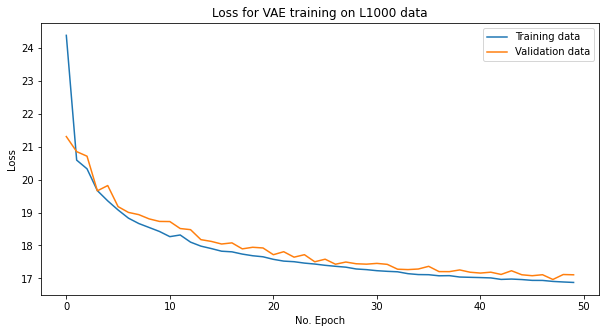

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on L1000 data")
# plt.ylabel("Binary cross entropy + KL Divergence")
plt.ylabel("Loss")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [15]:
# evaluating performance using test set
L1000_vae.vae.evaluate(test_features_df)

185/185 [==============================] - 1s 4ms/step - loss: 16.7059


16.705907821655273

In [16]:
reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

300.2139902404743

<AxesSubplot:>

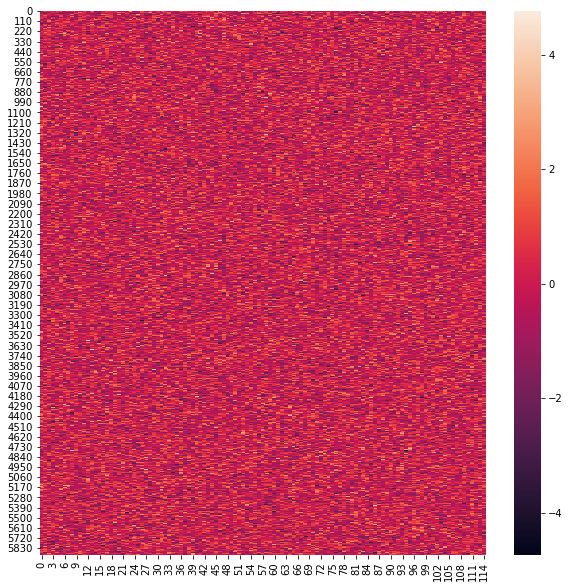

In [17]:
# latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = L1000_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

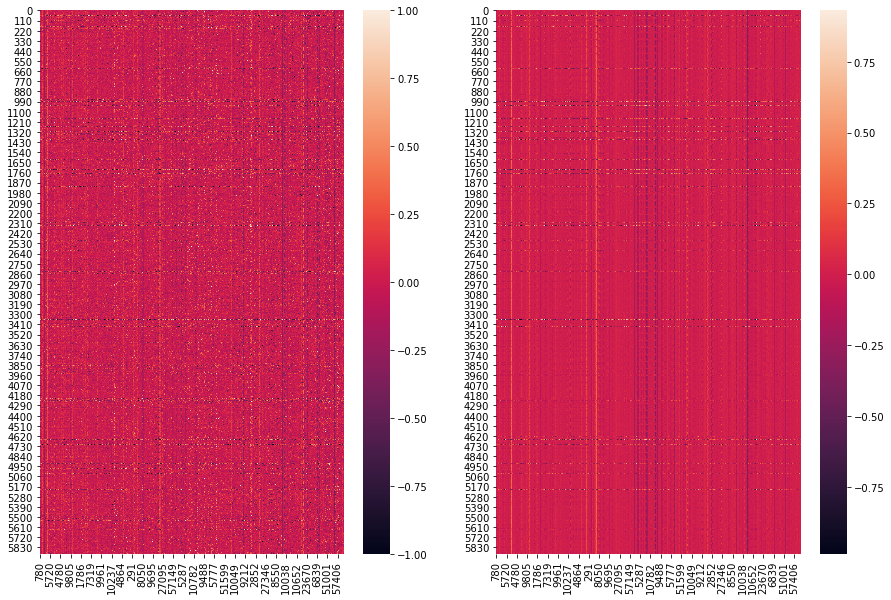

In [18]:
# original vs reconstructed heatmap
reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
seaborn.heatmap(test_features_df, ax=ax1)
seaborn.heatmap(reconstruction, ax=ax2)
plt.show()

<AxesSubplot:>

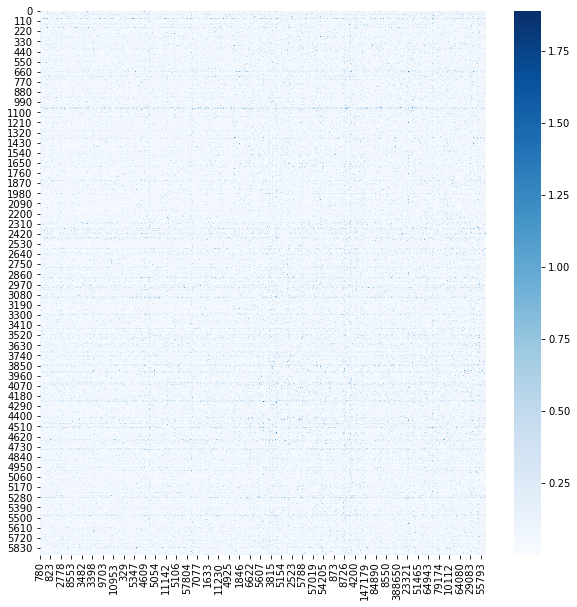

In [19]:
#difference between original and reconstructed heatmap
difference = abs(reconstruction - test_features_df)
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(difference, ax=ax, cmap="Blues")

<AxesSubplot:>

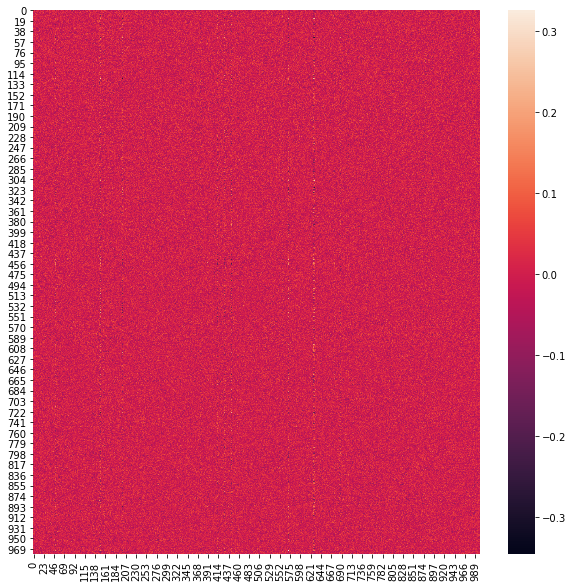

In [20]:
#encoder heatmap
weights = L1000_vae.encoder_block["encoder"].get_weights()
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(weights[0], ax=ax)

In [21]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/latent4.csv")

In [22]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder = L1000_vae.decoder_block["decoder"]
decoder.save('./heythere')

INFO:tensorflow:Assets written to: ./heythere/assets
